<a href="https://colab.research.google.com/github/VinayProgram/PointNetSegmention/blob/main/PointNetDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
!pip install numpy-stl trimesh tqdm
import os
import io
import requests
import numpy as np
import trimesh
from tqdm import tqdm

# Folder to save point clouds
os.makedirs("pointclouds", exist_ok=True)

# List of STL URLs (example from MedShapeNet)
workspace = [
    # Skull & head
    'skull',

    # Spine
    'cervical_spine',
    'thoracic_spine',
    'lumbar_spine',
    'sacrum',
    'coccyx',

    # Rib cage
    'rib_left',
    'rib_right',
    'sternum',

    # Shoulder girdle
    'clavicle_left',
    'clavicle_right',
    'scapula_left',
    'scapula_right',

    # Upper limbs
    'humerus_left',
    'humerus_right',
    'radius_left',
    'radius_right',
    'ulna_left',
    'ulna_right',
    'hand_left',
    'hand_right',

    # Pelvis
    'pelvis',

    # Lower limbs
    'femur_left',
    'femur_right',
    'patella_left',
    'patella_right',
    'tibia_left',
    'tibia_right',
    'fibula_left',
    'fibula_right',
    'foot_left',
    'foot_right'
]

url_list = "https://medshapenet.ikim.nrw/uploads/MedShapeNetDataset.txt"
response = requests.get(url_list)
stl_urls = [
    line.strip() for line in response.text.split("\n")
    if line.strip().endswith(".stl")
    and any(word in line for word in workspace)
]

# Define your classes
class_map = {
    # Skull & head
    'skull': 0,

    # Spine
    'cervical_spine': 1,
    'thoracic_spine': 2,
    'lumbar_spine': 3,
    'sacrum': 4,
    'coccyx': 5,

    # Rib cage
    'rib_left': 6,
    'rib_right': 7,
    'sternum': 8,

    # Shoulder girdle
    'clavicle_left': 9,
    'clavicle_right': 10,
    'scapula_left': 11,
    'scapula_right': 12,

    # Upper limbs
    'humerus_left': 13,
    'humerus_right': 14,
    'radius_left': 15,
    'radius_right': 16,
    'ulna_left': 17,
    'ulna_right': 18,
    'hand_left': 19,
    'hand_right': 20,

    # Pelvis
    'pelvis': 21,

    # Lower limbs
    'femur_left': 22,
    'femur_right': 23,
    'patella_left': 24,
    'patella_right': 25,
    'tibia_left': 26,
    'tibia_right': 27,
    'fibula_left': 28,
    'fibula_right': 29,
    'foot_left': 30,
    'foot_right': 31
}

In [37]:
import random
from collections import defaultdict

max_files = 100  # total number of files you want

# --- 1. Bucket URLs by class ---
class_buckets = defaultdict(list)
for url in stl_urls:
    fname = url.split("/")[-1].lower()
    for key in class_map.keys():
        if key in fname:
            class_buckets[key].append(url)
            break

# --- 2. Pick one STL per class (guarantee coverage) ---
selected_urls = []
for key in class_map.keys():
    if class_buckets[key]:
        selected_urls.append(class_buckets[key][0])  # first match

# --- 3. Randomly fill the remaining slots up to max_files ---
remaining_slots = max_files - len(selected_urls)
if remaining_slots > 0:
    all_remaining = [u for urls in class_buckets.values() for u in urls if u not in selected_urls]
    random.shuffle(all_remaining)  # randomize
    selected_urls.extend(all_remaining[:remaining_slots])

print(f"Selected {len(selected_urls)} URLs covering {len(class_buckets)} classes")



Selected 100 URLs covering 32 classes


In [38]:
import os
import io
import requests
import numpy as np
import trimesh
from tqdm import tqdm

# Ensure output folder exists
os.makedirs("pointclouds", exist_ok=True)

def stl_to_pointcloud_with_labels(stl_url, n_points=10000):
    try:
        resp = requests.get(stl_url, timeout=60)
        if resp.status_code != 200:
            return None

        filename = stl_url.split('/')[-1].lower()
        mesh = trimesh.load(io.BytesIO(resp.content), file_type='stl')

        # Sample points
        points = mesh.sample(n_points)

        # Normalize points
        points = points - points.mean(axis=0)
        points = points / np.max(np.linalg.norm(points, axis=1))

        # Assign per-point label based on filename
        label = -1
        matched_class = None
        for key, val in class_map.items():
            if key in filename:
                label = val
                matched_class = key
                break

        if label == -1:
            return None  # skip if no match

        labels = np.full(points.shape[0], label, dtype=np.int64)

        return {
            'points': points.astype(np.float32),
            'labels': labels,
            'class_name': matched_class
        }

    except Exception:
        return None


dataset = []
class_counts = {}

for i, url in enumerate(tqdm(selected_urls)):
    data = stl_to_pointcloud_with_labels(url)
    if data is not None:
        fname = f"pointclouds/{data['class_name']}_{i}.npz"
        np.savez(fname, points=data['points'], labels=data['labels'])

        dataset.append(data)
        class_counts[data['class_name']] = class_counts.get(data['class_name'], 0) + 1

print(f"\n✅ Saved {len(dataset)} point clouds to 'pointclouds/'")
print("📊 Class distribution:")
for k, v in class_counts.items():
    print(f"  {k}: {v}")



100%|██████████| 100/100 [06:04<00:00,  3.65s/it]


✅ Saved 97 point clouds to 'pointclouds/'
📊 Class distribution:
  rib_left: 39
  rib_right: 30
  scapula_left: 2
  scapula_right: 5
  humerus_left: 4
  humerus_right: 2
  femur_left: 2
  femur_right: 4
  skull: 6
  sacrum: 3


In [40]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os

class PointCloudSegDataset(Dataset):
    def __init__(self, folder_path, num_points=10000):
        self.files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".npz")]
        self.num_points = num_points

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        data = np.load(self.files[idx])
        pc = data['points']      # [N, 3]
        labels = data['labels']  # [N]

        # Sample fixed number of points
        if pc.shape[0] >= self.num_points:
            indices = np.random.choice(pc.shape[0], self.num_points, replace=False)
        else:
            indices = np.random.choice(pc.shape[0], self.num_points, replace=True)

        pc = pc[indices, :]
        labels = labels[indices]

        return torch.from_numpy(pc).float(), torch.from_numpy(labels).long()

# Dataloader
dataset = PointCloudSegDataset("pointclouds/")
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)


In [41]:
import torch.nn as nn
import torch.nn.functional as F
import torch

class PointNetFeat(nn.Module):
    def __init__(self):
        super(PointNetFeat, self).__init__()
        self.conv1 = nn.Conv1d(3, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)

    def forward(self, x):
        x = x.transpose(2, 1)  # [B, 3, N]
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        return x  # [B, 1024, N]

class PointNetSeg(nn.Module):
    def __init__(self, num_classes=2):
        super(PointNetSeg, self).__init__()
        self.feat = PointNetFeat()
        self.conv1 = nn.Conv1d(1024, 512, 1)
        self.conv2 = nn.Conv1d(512, 256, 1)
        self.conv3 = nn.Conv1d(256, num_classes, 1)

    def forward(self, x):
        x = self.feat(x)  # [B, 1024, N]
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)  # [B, num_classes, N]
        return x.transpose(2, 1)  # [B, N, num_classes]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PointNetSeg(num_classes=len(class_map)).to(device)


In [42]:
import torch.optim as optim
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 10
num_classes = len(class_map)

for epoch in range(epochs):
    model.train()
    running_loss = 0

    for pcs, labels in dataloader:
        pcs, labels = pcs.to(device), labels.to(device)  # pcs: [B, N, 3], labels: [B, N]

        optimizer.zero_grad()
        outputs = model(pcs)  # [B, N, num_classes]

        # Flatten for loss
        outputs = outputs.reshape(-1, num_classes)  # [B*N, num_classes]
        labels = labels.reshape(-1)                 # [B*N]

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(dataloader):.4f}")


Epoch 1/10, Loss: 2.4999
Epoch 2/10, Loss: 1.9636
Epoch 3/10, Loss: 1.7949
Epoch 4/10, Loss: 1.7748
Epoch 5/10, Loss: 1.7160
Epoch 6/10, Loss: 1.7213
Epoch 7/10, Loss: 1.6787
Epoch 8/10, Loss: 1.5398
Epoch 9/10, Loss: 1.5139
Epoch 10/10, Loss: 1.4626


In [43]:
!pip install open3d
import open3d as o3d
import matplotlib.pyplot as plt
import torch

# Pick a sample point cloud
model.eval()
with torch.no_grad():
    sample_pc, sample_label = dataset[0]         # [N, 3], [N]
    pcs_tensor = sample_pc.unsqueeze(0).to(device)  # [1, N, 3]

    # Predict per-point classes
    output = model(pcs_tensor)                   # [1, N, num_classes]
    preds = torch.argmax(output, dim=2).squeeze(0).cpu().numpy()  # [N]

# Convert to Open3D point cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(sample_pc.numpy())

# Assign colors based on predicted class
num_classes = len(class_map)
colors = plt.get_cmap("tab20")(preds / num_classes)[:, :3]
pcd.colors = o3d.utility.Vector3dVector(colors)

# Save to PLY
o3d.io.write_point_cloud("segmented_sample.ply", pcd)
print("Saved segmented point cloud as 'segmented_sample.ply'")

# Optional: visualize in Open3D
o3d.visualization.draw_geometries([pcd])


Saved segmented point cloud as 'segmented_sample.ply'
[Open3D WARNING] GLFW initialized for headless rendering.
[Open3D WARNING] GLFW Error: OSMesa: Library not found
[Open3D WARNING] Failed to create window
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


In [44]:
!pip install open3d
import trimesh
import numpy as np
import torch

# 1. Load STL
mesh = trimesh.load("body_1.stl")

# 2. Sample points
num_points = 10000  # same as training
points = mesh.sample(num_points)

# 3. Normalize
points = points - points.mean(axis=0)
points = points / np.max(np.linalg.norm(points, axis=1))

# 4. Convert to tensor
points_tensor = torch.from_numpy(points).float().unsqueeze(0).to(device)  # [1, N, 3]


In [45]:
model.eval()
with torch.no_grad():
    output = model(points_tensor)                  # [1, N, num_classes]
    preds = torch.argmax(output, dim=2).squeeze(0)  # [N]
    preds = preds.cpu().numpy()
    print("Predicted classes per point:", np.unique(preds))


Predicted classes per point: [4 6 7]


In [46]:
print(points.shape, preds.shape)
print(points.dtype, preds.dtype)


(10000, 3) (10000,)
float64 int64


Points: (10000, 3) float64
Preds: (10000,) int64
Unique classes: [4 6 7]
Saved: True -> body_segmented.ply


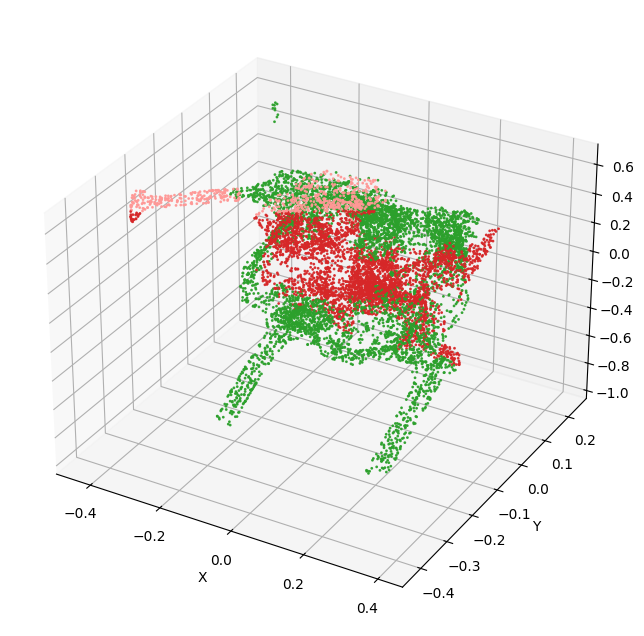

In [47]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Example: points and preds must come from your model
# points = np.array([...])   # shape (N, 3)
# preds  = np.array([...])   # shape (N,) integers
# class_map = {...}          # your class_map dictionary

# --- Safety checks ---
print("Points:", points.shape, points.dtype)
print("Preds:", preds.shape, preds.dtype)
print("Unique classes:", np.unique(preds))

# --- Create colors ---
num_classes = len(class_map)
cmap = plt.get_cmap("tab20")

# assign one color per class index
colors = np.array([cmap(int(c) % 20)[:3] for c in preds])

# --- Create Open3D PointCloud ---
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points.astype(np.float64))
pcd.colors = o3d.utility.Vector3dVector(colors.astype(np.float64))

# --- Save to PLY ---
success = o3d.io.write_point_cloud("body_segmented.ply", pcd)
print("Saved:", success, "-> body_segmented.ply")

# --- Visualize in matplotlib (Colab-friendly) ---
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2],
           c=colors, s=1, alpha=0.9)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()
